<a href="https://colab.research.google.com/github/ShabnaIlmi/Bank-Marketing-Random-Forest-and-Neural-Networks/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


In [3]:
# Loading the dataset with the proper delimiter (semicolon)
data_full_additional = pd.read_csv('/content/drive/MyDrive/Bank-Marketing-Random-Forest-and-Neural-Networks/bank-additional-full.csv', delimiter=';')


In [4]:
# Displaying the data contained within the dataset
data_full_additional.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# **Data Cleaning**

Removing whitespaces from the object type columns

In [5]:
# Removing whitespaces from the object type column
object_columns = data_full_additional.select_dtypes(include=['object']).columns
data_full_additional[object_columns] = data_full_additional[object_columns].apply(lambda x: x.str.strip())

Removing unnecessary fullstops(" . ") near the admin in the job column

In [6]:
# Removing unnecessary full stops(".") from the 'job' column
data_full_additional['job'] = data_full_additional['job'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)

## **Removing Duplicates**

Eliminating the duplicate values from the dataset

In [7]:
# Removing duplicates
print(f"Initial dataset shape: {data_full_additional.shape}")
data_full_additional = data_full_additional.drop_duplicates()
print(f"Shape after removing duplicates: {data_full_additional.shape}")

Initial dataset shape: (41188, 21)
Shape after removing duplicates: (41176, 21)


In [8]:
# Display dataset information
print("Dataset Information:")
print(data_full_additional.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx  

## **Handling Missing Data**

Handling missing values in the categorical columns

In [9]:
# Handling "unknown" values in categorical features
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

In [10]:
# Creating an empty list
unknown_values = []

# Checking for 'unknown' values in the data of categorical columns
for col in categorical_cols:
    unknown_count = (data_full_additional[col] == 'unknown').sum()
    if unknown_count > 0:
        unknown_values.append({'Column': col, 'Count': unknown_count})

# Converting the list into a pandas DataFrame
unknown_values_df = (
    pd.DataFrame(unknown_values)
    .sort_values(by='Count', ascending=False)
    .reset_index(drop=True)
)

# Displaying the DataFrame
print("\nColumns with 'unknown' values and their counts:")
print()
print(unknown_values_df)



Columns with 'unknown' values and their counts:

      Column  Count
0    default   8596
1  education   1730
2    housing    990
3       loan    990
4        job    330
5    marital     80


In [11]:
# Displaying the unique values and their counts relevant to each column containing "unknown" values
for _, row in unknown_values_df.iterrows():
    col = row['Column']
    unique_values = data_full_additional[col].unique()
    value_counts = data_full_additional[col].value_counts()
    print(value_counts)
    print(" ")

default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
 
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
 
housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64
 
loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64
 
job
admin            10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
 
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
 


In [12]:
# List of categorical columns to handle specifically with mode
columns_to_handle_with_mode = ['marital', 'default', 'housing', 'loan']

# Replacing "unknown" with NaN for imputation
data_full_additional[columns_to_handle_with_mode] = data_full_additional[columns_to_handle_with_mode].replace('unknown', np.nan)

Replacing the missing ("unknown values changed to NaN for imputation") data contained within the "loan" column with the mode ("no") since the mode represents more than 80% of this column this is considered as the most optimal choice to handle those missing values. Additionally, missing values in the columns, martial and housing also replaced with the mode since more than 60% of those columns also consists of the mode and those columns has comparably less number of missing values.

In [13]:
# Replacing NaN with the mode in the specified columns (loan, martial and housing)
for col in columns_to_handle_with_mode:
    mode_value = data_full_additional[col].mode()[0]
    data_full_additional[col] = data_full_additional[col].fillna(mode_value)

Checking for columns which contains unhandled missing values

In [14]:
# Verifying the changes and checking for the columns which contain 'unknown' values
print("\nColumns with 'unknown' values and their counts:\n")
for _, row in unknown_values_df.drop_duplicates(subset='Column').iterrows():
    col = row['Column']
    # Count the number of "unknown" values in the column
    unknown_count = data_full_additional[col].str.contains('unknown', case=False, na=False).sum()
    if unknown_count > 0:
        print(f"{col} : {unknown_count}")


Columns with 'unknown' values and their counts:

education : 1730
job : 330


Considering the missing values in the columns, "job" and "education" as a seperate category during the encoding process

Encoding the non-ordinal categorical variables using one-hot encoding

In [15]:
#  One-hot encoding for non-ordinal categorical variables
non_ordinal_cols = ['job', 'marital', 'contact', 'poutcome', 'month', 'day_of_week']
data_full_additional = pd.get_dummies(data_full_additional, columns=non_ordinal_cols, drop_first=True)

Encoding the ordinal categorical variables using labeled encoding

In [16]:
# Mapping ordinal categorical variables
education_mapping = {
    'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school': 5,
    'professional.course': 6, 'university.degree': 7, 'unknown': 0
}
default_mapping = {'no': 0, 'yes': 1}
housing_mapping = {'no': 0, 'yes': 1}
loan_mapping = {'no': 0, 'yes': 1}

data_full_additional['education'] = data_full_additional['education'].map(education_mapping)
data_full_additional['default'] = data_full_additional['default'].map(default_mapping)
data_full_additional['housing'] = data_full_additional['housing'].map(housing_mapping)
data_full_additional['loan'] = data_full_additional['loan'].map(loan_mapping)

Excluding the 'duration' feature to avoid data leakage, as it directly depends on the outcome
and would not be available at the time of prediction in a real-world scenario.

In [17]:
# Excluding the 'duration' feature for realistic predictive modeling
data_full_additional = data_full_additional.drop(columns=['duration'])

Excluding the default column since one case (" no ") dominates more than 90% of that column

In [18]:
# Excluding the duration column since more than 90% of the data in the column is dominated by the value "no"
data_full_additional = data_full_additional.drop(columns=['default'])

Checking the unique values of the "pdays" column with the relavant percentage

In [19]:
# Calculating value counts and percentages
value_counts = data_full_additional['pdays'].value_counts(normalize=True) * 100

# Displaying unique values with percentages
print("Unique values in the 'pdays' column with their percentages:")
print(" ")
print(value_counts)

Unique values in the 'pdays' column with their percentages:
 
pdays
999    96.320672
3       1.066155
6       1.000583
4       0.286575
9       0.155430
2       0.148145
7       0.145716
12      0.140859
10      0.126287
5       0.111716
13      0.087430
11      0.068001
1       0.063144
15      0.058286
14      0.048572
8       0.043715
0       0.036429
16      0.026715
17      0.019429
18      0.017000
22      0.007286
19      0.007286
21      0.004857
25      0.002429
26      0.002429
27      0.002429
20      0.002429
Name: proportion, dtype: float64


Checking the correlation between the pdays and the target variable(y) since the dominating value of the pdays column is 999 which is more than 96% of the entire column

In [20]:
# Testing the correlation between the pdays column and the target variable (y)
correlation = data_full_additional['pdays'].corr(data_full_additional['y'].map({'yes': 1, 'no': 0}))
print(f"Correlation between 'pdays' and 'y': {correlation}")

Correlation between 'pdays' and 'y': -0.32494758638558474


The correlation between pdays and the target column y is -0.32494758638558474, which indicates a moderate negative relationship. This suggests that pdays provides some predictive information about the target variable. Which makes it inaccurate in eliminate the 'pdays' column

In [ ]:
# Scaling numerical features
numerical_cols = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]
scaler = StandardScaler()
data_full_additional[numerical_cols] = scaler.fit_transform(data_full_additional[numerical_cols])

In [ ]:
# Target encoding
# Encoding the target variable (y)
data_full_additional['y'] = data_full_additional['y'].map({'yes': 1, 'no': 0})

In [ ]:
# Adding derived features from numerical data
data_full_additional['interaction_emp_cons'] = data_full_additional['emp.var.rate'] * data_full_additional['cons.price.idx']
data_full_additional['interaction_nr_employed_conf'] = data_full_additional['nr.employed'] * data_full_additional['cons.conf.idx']

In [ ]:
# Spliting features and target variable
X_full_additional = data_full_additional.drop(columns=['y'])
y_full_additional = data_full_additional['y']


In [ ]:
# Splitting the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(
    X_full_additional, y_full_additional, test_size=0.2, random_state=42
)

# **Visulaization**

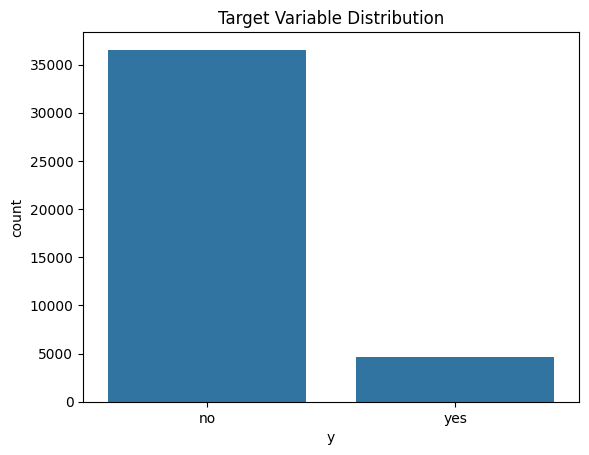

In [26]:
# Visualizing the distribution of the target variable
sns.countplot(data=data_full_additional, x='y')
plt.title('Target Variable Distribution')
plt.show()

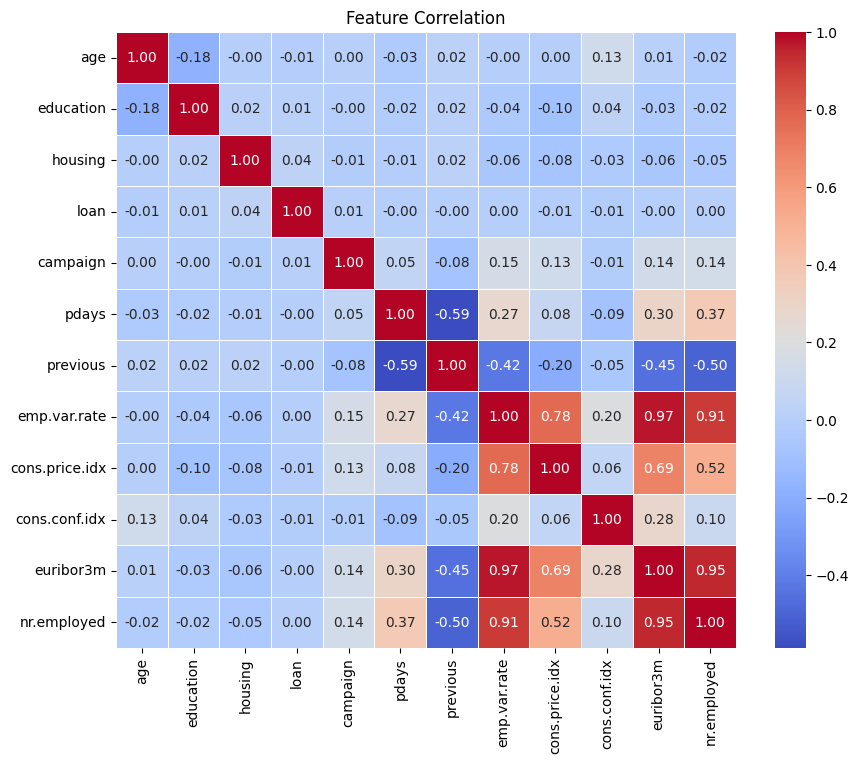

In [28]:
# Ensure all non-numeric columns are excluded
numeric_data = data_full_additional.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Optional: Adjust the figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation')
plt.show()